In [1]:
date = '2017-08-30'
fn = 'DB-backup/%s/cyclings_vid1.json' % date

In [2]:
%matplotlib inline

In [3]:
import json

In [4]:
data = json.load(open(fn))

In [5]:
import pandas as pd

In [6]:
dfs = {}
for i, item in enumerate(data):
    if item['type']=='table':
        name = item['name']
        if name not in ( 'video2seg_temp'):
            print(i,item['name'])
            dfs[name] = pd.DataFrame(item['data'])

2 loginLog
3 Rating
4 RoadSegment
5 Users
6 Video
8 VideoRoadSeg


# Statistics of Users:

- completeness of survey
- number of users in each exp-lvl group

In [7]:
users = dfs['Users']
users.shape

(50, 15)

{'1': 42, 0: 8}


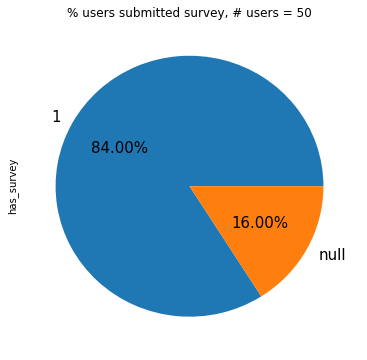

In [22]:
print(users.has_survey.fillna(0).value_counts().to_dict())
users.has_survey.fillna('null').value_counts().plot(kind='pie',autopct='%.2f%%', figsize=(6,6), fontsize=15, title='%% users submitted survey, # users = %d' % users.shape[0])

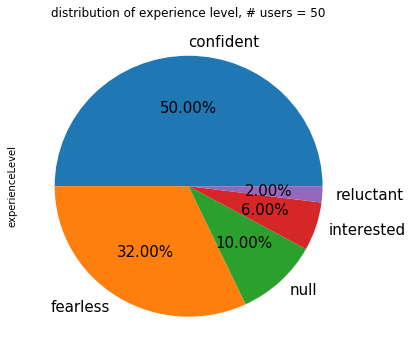

In [23]:
users.experienceLevel.fillna('null').value_counts().plot(kind='pie',autopct='%.2f%%', figsize=(6,6), fontsize=15,
                                                        title = 'distribution of experience level, # users = %d' % users.shape[0])

In [18]:
survey_dict = {
    'bk_purpose': ['Mainly utility biking – traveling from one location to another', 'Mainly recreational biking – biking for recreation, leisure, and health', '50% utility, 50% recreational'],
    'age': ['< 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '>=75', '', '', '', ],
    'ethnicity': ['White', 'Hispanic or Latino', 'Black or African American', 'Native American or American Indian', 'Asian / Pacific Islander', 'Other',],
    'edu': ['Nursery school to some high school, no diploma', 'High school graduate, diploma or the equivalent (for example: GED)', 'Some college credit, no degree', 'Associate degree', 'Bachelor’s degree', 'Master’s degree', 'Doctorate degree'],
    'marital': ['Single, never married', 'Married or domestic partnership', 'Widowed', 'Divorced', 'Separated'],
    'gender': ['Female', 'Male', 'Transgender – Female', 'Transgender – Male', 'Gender-variant / Non-conforming', 'Not listed', ],
    'driver': ['yes', 'no'],
    'car': ['yes', 'no'],
    'household_income': ['Less than $24,999', '$25,000 to $39,999', '$40,000 to $54,999', '$55,000 to $69,999', '$70,000 to $84,999', '$85,000 to $99,999', '$100,000 to $149,999', '$150,000 or more'],
    'residence': ['Never', '<3 months', '3-6 months', '6-12 months', '1-3 years', '>=3 years'],
    'bk_type': ['CaBi Bike (Shared bike in the DC region)', 'Road Bike', 'Mountain Bike', 'Hybrid Bike', 'Cruiser Bike', 'BMX Bike', 'Folding Bike', 'Recumbent Bike', 'Tandem Bike', 'Do not ride a bike'],
}

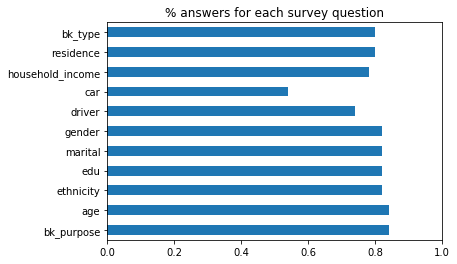

In [30]:
survey_cols = ['bk_purpose', 'age', 'ethnicity', 'edu', 'marital', 'gender', 'driver','car', 'household_income', 'residence', 'bk_type']
(~users[survey_cols].isnull()).mean().plot(kind='barh', xlim =(0,1), title='% answers for each survey question')

# Statistics of loginLog

- distribution of # logins per user
- mobile vs PC
- distribution over time

In [34]:
logs = dfs['loginLog']
logs = logs.merge(users[['user_id', 'email']])

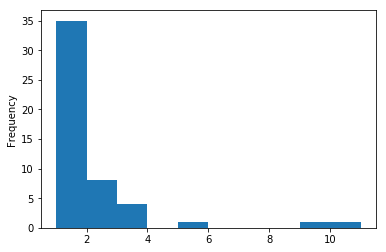

In [55]:
logs.groupby('user_id').count().lid.plot(kind='hist')

not Mobile    68
mobile        20
Name: isMobile, dtype: int64

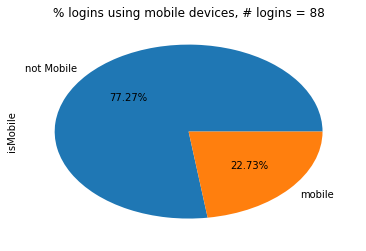

In [57]:
logs.isMobile.apply(lambda x: 'not Mobile' if x=='' else 'mobile').value_counts().plot('pie',
                                                                                       autopct='%.2f%%', 
                                                                                       title='%% logins using mobile devices, # logins = %d' % logs.shape[0])
logs.isMobile.apply(lambda x: 'not Mobile' if x=='' else 'mobile').value_counts()

In [46]:
logs.timezone = logs.timezone.apply(lambda x: x.replace('GMT', '').strip()).apply(lambda x: 0 if x=='' else int(x))
logs['offset'] = logs.timezone.apply(lambda x: abs(x))
logs['direction'] = logs.timezone.apply(lambda x: 1 if x>0 else -1)
logs['time'] = pd.to_datetime(logs.UTCts)
logs['time'] = logs.apply(lambda x: x.time + x.direction * pd.to_timedelta(x.offset, unit='h'), axis=1)

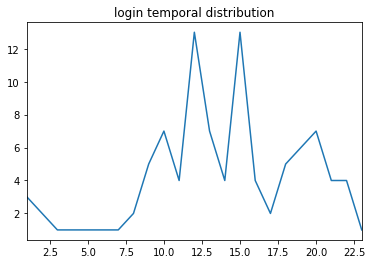

In [47]:
logs.time.apply(lambda x: x.hour).value_counts().sort_index().plot(title='login temporal distribution')

# Statistics of Ratings

- distribution of # ratings per user
- distribution of # ratings per login
- distribution of scores: overall; groupby user exp-lvl
- distribution of tags: overall; groupby score; groupby user exp-lvl
- agg comments
- normal rating(no skipping)
- aggregate comments and scores on a video/segment basis

In [48]:
ratings = dfs['Rating'].drop('email', axis=1)
videos=dfs['Video']
videos.shape,ratings.vid.nunique()

((549, 4), 288)

In [49]:
ratings = ratings.merge(users[['user_id','email']], left_on='uid', right_on='user_id').drop('uid', axis=1).merge(videos[['vid','URL']])
ratings.URL = ratings.URL.apply(lambda x: 'https://www.youtube.com/watch?v='+x)

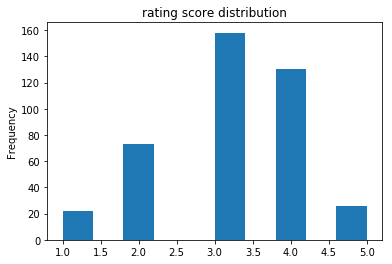

In [52]:
ratings.score.astype(float).plot(kind='hist',title='rating score distribution')

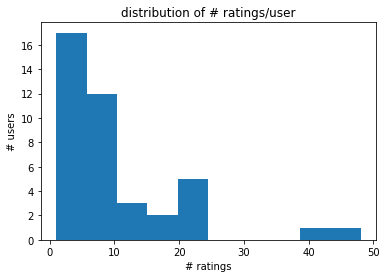

In [62]:
ax = ratings.groupby('user_id').count().email.plot(kind='hist', title = 'distribution of # ratings/user')
ax.set_xlabel('# ratings')
ax.set_ylabel('# users')

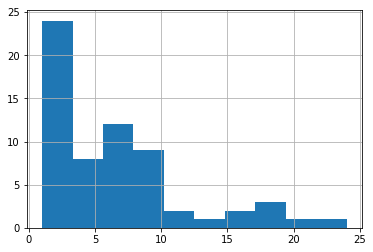

In [14]:
ratings.groupby('lid').count().email.hist()

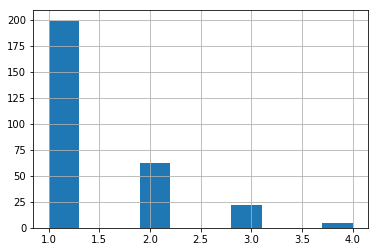

In [68]:
ratings.groupby('vid').count().email.hist()

In [97]:
ratings.iloc[407].comment

"High-speed, 3 lanes 1-way? I'll take the sidewalk thanks. "

In [93]:
ratings_w_comment = ratings[ratings.comment!='']
ratings_w_comment[['vid','comment','URL','score']].sort_values('vid')

,vid,comment,URL,score
99,102,"cobbles, narrow road, and rail tracks",https://www.youtube.com/watch?v=0SP5QFb3E98,2
50,108,"there are bike lanes on this road, more danger...",https://www.youtube.com/watch?v=Shz6cazUaa8,2
396,11,Q11 (what type of bike do you normally ride)\r...,https://www.youtube.com/watch?v=Hc_wZfeazVU,3
203,115,What's dangerous is going from bike lane to no...,https://www.youtube.com/watch?v=m9qvDsQrNXI,3
37,120,I would not transition to the sidewalk. That i...,https://www.youtube.com/watch?v=RSxhtMim6nA,4
77,123,bikes are better on roads than sidewalks... if...,https://www.youtube.com/watch?v=S-A71a0YRmE,2
75,123,I wouldn't ride on the sidewalk. Too narrow.,https://www.youtube.com/watch?v=S-A71a0YRmE,3
52,124,Rating not applicable — cyclist is riding on t...,https://www.youtube.com/watch?v=Suti47cmzew,3
53,124,riding on the sidewalk and jumping a red light,https://www.youtube.com/watch?v=Suti47cmzew,1
247,143,I don't quite understand the idea of rating a ...,https://www.youtube.com/watch?v=kpqZ0Cio_tA,4


# Statistics of Segments

- distribution of number of ratings per segment
- distribution of std of score per segment

In [70]:
segs = dfs['RoadSegment']

In [74]:
segs[segs['sumCnt']!='0'].shape

(314, 7)